In [1]:
import os
os.environ['DISPLAY'] = ':1'
os.environ["CUDA_VISIBLE_DEVICES"]=""

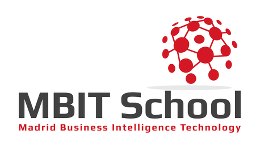
# Deej-A.I.
### Create automatic playlists by using Deep Learning to *listen* to the music
Robert Dargavel Smith - Advanced Machine Learning end of Masters project (MBIT School, Madrid, Spain)

### Motivation

* Just as a DJ has an intuition for which songs go well together, I thought AI could learn to recommend songs based on simply *listening* to them
* Using genres to recommend songs is limiting and uncreative
* Is it possible to organize music using a smooth, higher dimensional representation, so that songs with similar energy, mood or instrumentation are grouped together?
* How can I leverage off publicly available data to build up an encyclopaedic knowledge of music? 

### Data
* I scraped 240,000 playlists containing 4 million unique songs from Spotify using the API
* The only way to do this was to search for all the playlists with the letter 'a' in the name, up to 'Z'
* The playlists give context to the songs in the same way as sentences give context to the words contained in them
* People tend to make playlists of of songs by similar artists, with a similar mood, style, genre or for a particular purpose
* I excluded all playlists curated by Spotify

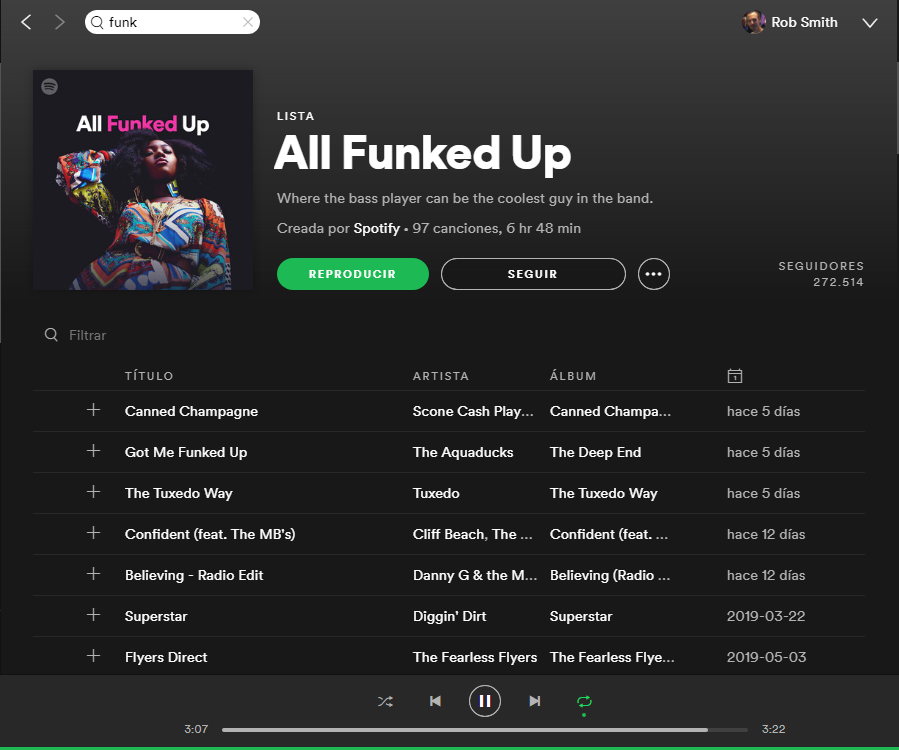

### Track2Vec embedding
* I trained a Word2Vec model to create an embedding by considering each song as a "word" and each playlist as a "sentence"
* I limited the "vocabulary" to those which appeared in at least 10 playlists, leaving me with 450,000 tracks
* During training, I subjectively monitored the nearest neighbours of a set of validation tracks
* I trained 15 epochs of 10,000 batch "words" before overfitting set in
* I found 100 dimensions to be a good size (see later)

In [2]:
import gensim
from gensim.models.callbacks import CallbackAny2Vec
class logger(CallbackAny2Vec):
    None
    
embedding_model = gensim.models.Word2Vec.load('word2vec.model')
print(embedding_model)
embedding = embedding_model.wv.syn0

Word2Vec(vocab=452130, size=100, alpha=0.025)


<ipython-input-2-05bfbe58fd9e>:8: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  embedding = embedding_model.wv.syn0


In [3]:
import csv
print('Read in tracks...')
tracks = {}
with open('popular_tracks.csv', "r", encoding='utf-8') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=';')
    for row in spamreader:
        columns = str(row)[2:-2].split(';')
        tracks[columns[0]] = [columns[1] + ' - ' +
                              columns[2], columns[3]] # title - artist, url
print(f'Number of tracks: {len(tracks)}')

Read in tracks...
Number of tracks: 452130


In [4]:
import random
word_vectors = []
track_names = []
for track in tracks:
    if random.uniform(0, 1) > 10000 / len(tracks):
        continue
    track_names.append(tracks[track][0])
    word_vectors.append(embedding[embedding_model.wv.vocab[track].index])

# importing bokeh library for interactive data visualization
import pandas as pd
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook

# defining the chart
output_notebook()
fig = bp.figure(plot_width=700, plot_height=600, title="A map of MP3ToVec vectors",
                tools="pan,wheel_zoom,box_zoom,reset,hover",
                x_axis_type=None, y_axis_type=None, min_border=1)

# dimensionality reduction. converting the vectors to 2d vectors
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=0, random_state=0)
tsne_w2v = tsne_model.fit_transform(word_vectors)

# putting everything in a dataframe
tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
tsne_df['words'] = track_names

# plotting. the corresponding word appears when you hover on the data point.
fig.scatter(x='x', y='y', source=tsne_df)
hover = fig.select(dict(type=HoverTool))
hover.tooltips={"": "@words"}

Loading BokehJS ...

In [5]:
show(fig) # t-SNE plot of Track2Vec embedding

In [6]:
search = 'camilo sesto vivir'
id = [track for track in tracks if all(word in tracks[track][0].lower() for word in search.lower().split())][0]
print(f'Tracks most similar to {tracks[id][0]}')
most_similar_tracks = embedding_model.wv.most_similar(positive=[id], topn=10)
for i, track in enumerate(most_similar_tracks):
    print(f'{i+1}. {tracks[track[0]][0]}')

Tracks most similar to Camilo Sesto - Vivir Así Es Morir de Amor
1. Raffaella Carrà - Caliente, Caliente
2. Los Diablos - Un Rayo De Sol
3. Tino Casal - Eloise
4. Azucar Moreno - Bandido
5. Rocío Jurado - Como una Ola
6. Los Rebeldes - Bajo la Luz de la Luna
7. Paloma San Basilio - Juntos
8. Los Sencillos - Bonito Es
9. Dinamita Pa Los Pollos - Bourbon
10. Los Rebeldes - Mediterraneo


### Spectrogram to Track2Vec ConvNet
* I downloaded 30 second MP3 samples of all the tracks in the embedding "vocabulary" from Spotify
* Then I converted these to mel spectrograms as a compact representation which reflects how the human ear responds to sound
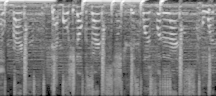
* I divided the spectograms up into 80% training, 20% validation
* I trained a convolutional neural network to reproduce as closely as possible (in cosine proximity) the Track2Vec vector (output $y$) corresponding to a given spectrogram (input $x$)

In [7]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout, LeakyReLU,\
        SeparableConv2D, Convolution2D, MaxPooling2D, BatchNormalization, Flatten

input_shape = (96, 216, 1)
model_input = Input(input_shape, name='input')
layer = model_input

layer = SeparableConv2D(32, 3, padding="same")(layer)
layer = LeakyReLU(0.2)(layer)
layer = BatchNormalization()(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = Dropout(rate=0.2)(layer)

layer = SeparableConv2D(64, 3, padding="same")(layer)
layer = LeakyReLU(0.2)(layer)
layer = BatchNormalization()(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = Dropout(rate=0.3)(layer)

layer = SeparableConv2D(128, 3, padding="same")(layer)
layer = LeakyReLU(0.2)(layer)
layer = BatchNormalization()(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = Dropout(rate=0.4)(layer)

layer = Flatten()(layer)
layer = Dense(1024)(layer)
layer = LeakyReLU(0.2)(layer)
layer = BatchNormalization()(layer)
layer = Dropout(rate=0.5)(layer)

layer = Dense(embedding.shape[1])(layer)
model_output = layer
model = Model(model_input, model_output)
model.compile(loss="cosine_proximity", optimizer="adam")

import keras
import pydot
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
keras.utils.vis_utils.pydot = pydot
model_dot = model_to_dot(model, show_shapes=True, show_layer_names=True, dpi=65).create(prog='dot', format='svg')

Using TensorFlow backend.


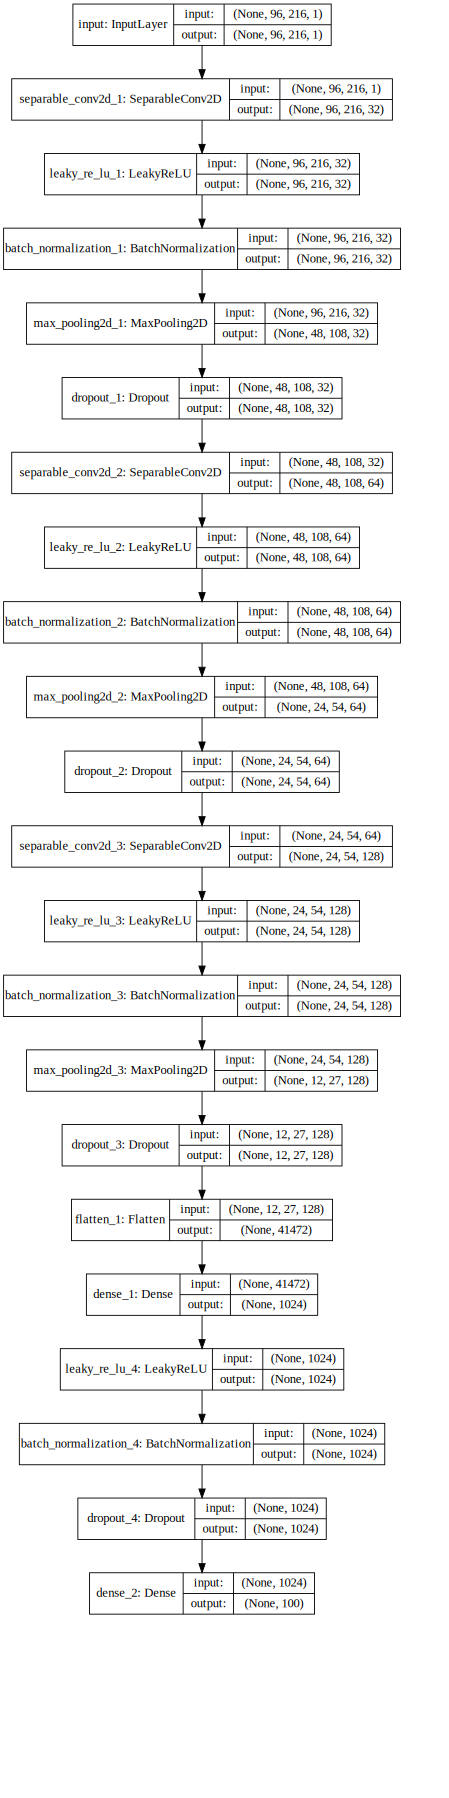

In [8]:
SVG(model_dot) # Show architecture of convolutional network

* I tried both one dimensional (in the time axis) and two dimensional convolutional networks and compared the results to a baseline model
* With a 100-dimensional embedding the best validation score I obtained before overfitting was 0.70 out of a possible 1.00
* With a 300-dimensional embedding the validation score was higher, but there was less difference between this and the baseline model
* I choose 100 dimensions to favour a latent representation with more diversity and capacity for discrimination
* I experimented with an Auto-Encoder and a Variational Auto-Encoder to try to force a more meaningful and disentangled latent representation of the spectrograms but left this for future research

### From Track2Vec to MP3ToVec
* I mapped 8,000 MP3s from my library to a series of Track2Vec vectors corresponding to each 5 second time slice
* Similar to the Doc2Vec model, I calculated a "MP3ToVec" vector for each MP3 including each constituent Track2Vec vector according to its TF-IDF (Term Frequency, Inverse Document Frequency) weight
* Two vectors were considered to correspond to identical tracks if they were within a proximity of $\epsilon$ (0.001)
* It was necessary to break the library of MP3s into batches of 100 (otherwise it would have taken 10 days to finish!)

### TF-IDF (Term Frequency, Inverse Document Frequency)
$$\mathrm{tfidf}(t,d,D) = \mathrm{tf}(t,d) \cdot \mathrm{idf}(t,D) \\
\mathrm{tf}(t,d) = f_{t, d} \\
\mathrm{idf}(t, D) =  \log \frac{N}{|\{d \in D: t \in d\}|}$$

where $f_{t, d}$ is the number of times that the track (word) $t$ appears in MP3 (document) $d$, $D$ is the set or "corpus" of all MP3s (all documents) and $N$ is the total number of MP3s (documents) in $D$.

In [9]:
import pickle
mp3tovec = pickle.load(open('../Pickles/mp3tovecs/mp3tovec.p', 'rb'))

In [10]:
word_vectors = [mp3tovec[w] for w in list(mp3tovec.keys())]
track_names = list(mp3tovec.keys())

# defining the chart
output_notebook()
fig = bp.figure(plot_width=700, plot_height=600, title="A map of MP3ToVec vectors",
                tools="pan,wheel_zoom,box_zoom,reset,hover",
                x_axis_type=None, y_axis_type=None, min_border=1)

# dimensionality reduction. converting the vectors to 2d vectors
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=0, random_state=0)
tsne_w2v = tsne_model.fit_transform(word_vectors)

# putting everything in a dataframe
tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
tsne_df['words'] = track_names

# plotting. the corresponding word appears when you hover on the data point.
fig.scatter(x='x', y='y', source=tsne_df)
hover = fig.select(dict(type=HoverTool))
hover.tooltips={"": "@words"}

Loading BokehJS ...

In [11]:
show(fig) # t-SNE plot of MP3ToVec embedding

In [21]:
import os
import time
from subprocess import Popen
from mutagen.id3 import ID3
from mutagen.mp4 import MP4
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import subprocess
import numpy as np
from IPython.core.display import HTML
from IPython.display import Audio, display

def munge(filename):
    if os.name == 'nt':
        return filename
    else:
        return filename.replace('\\', '/').replace(':', '_')

def most_similar(positive=[], negative=[], topn=5):
    if isinstance(positive, str):
        positive = [positive] # broadcast to list
    if isinstance(negative, str):
        negative = [negative] # broadcast to list
    mp3_vec_i = np.sum([mp3tovec[i] for i in positive] + [-mp3tovec[i] for i in negative], axis=0)
    similar = []
    for track_j in mp3tovec:
        if track_j in positive or track_j in negative:
            continue
        mp3_vec_j = mp3tovec[track_j]
        cos_proximity = np.dot(mp3_vec_i, mp3_vec_j) / (np.linalg.norm(mp3_vec_i) * np.linalg.norm(mp3_vec_j))
        similar.append((track_j, cos_proximity))
    return sorted(similar, key=lambda x:-x[1])[:topn]

def make_playlist(seed_tracks, size=10, lookback=1):
    playlist = seed_tracks
    while len(playlist) < size:
        candidates = most_similar(positive=playlist[-lookback:], topn=5)
        for i in range(5):
            if not candidates[i][0] in playlist:
                break
        playlist.append(candidates[i][0])
    return playlist

def get_track_details(tracks):
    details = []
    for file in tracks:
        artist = track = album = None
        if file[-3:].lower() == 'm4a':
            audio = MP4(munge(file))
            try:
                artist = audio['\xa9ART'][0]
            except:
                pass
            try:
                track = audio['\xa9nam'][0]
            except:
                pass
            try:
                album = audio['\xa9alb'][0]
            except:
                pass
        elif file[-3:].lower() == 'mp3':
            try:
                audio = ID3(munge(file))
                try:
                    artist = audio['TPE1'].text[0]
                except:
                    pass
                try:
                    track = audio["TIT2"].text[0]
                except:
                    pass
                try:
                    album = audio["TALB"].text[0]
                except:
                    pass
            except:
                pass
        if (artist, track, album) == (None, None, None):
            artist = file
        details.append((artist, track, album))
    return details

def print_track_details(track_details):
    for i, track_detail in enumerate(track_details):
        if len(track_detail) == 1:
            print(f'{i+1}. {track_detail[0]}')
        else:
            print(f'{i+1}. {track_detail[0]} - {track_detail[1]}')

def play_playlist(playlist, inline=False):
    if inline:
        track_details = get_track_details(playlist)
        for i, track in enumerate(playlist):
            track_detail = track_details[i]
            if len(track_detail) == 1:
                display(HTML(f'<h2>{i+1}. {track_detail[0]}</h2>'))
            else:
                display(HTML(f'<h2>{i+1}. {track_detail[0]} - {track_detail[1]}</h2>'))
            display(Audio(track))
        return
    if os.name == 'nt':
        player = "C:\\Program Files\\VideoLAN\\VLC\\vlc.exe"
        char = '\r'
    else:
        player = "vlc"
        char = '\n'
    try:
        for i, track in enumerate(playlist):
            with Popen([player, munge(track)]) as p:
                start = time.time()
                # quick way to get duration of song in seconds
                args=("ffprobe", "-show_entries", "format=duration", "-i", munge(track))
                popen = Popen(args, stdout = subprocess.PIPE)
                popen.wait()
                output = popen.stdout.read()
                duration = output.decode('utf-8')[19:]
                duration = float(duration[:duration.find(char)])
                while time.time() - start < duration and p.poll() == None:
                    pass
                p.terminate()
    except KeyboardInterrupt:
        p.terminate()
        raise
    p.terminate()
    
def most_similar_by_vec(positive=[], negative=[], topn=5):
    if isinstance(positive, str):
        positive = [positive] # broadcast to list
    if isinstance(negative, str):
        negative = [negative] # broadcast to list
    mp3_vec_i = np.sum([i for i in positive] + [-i for i in negative], axis=0)
    similar = []
    for track_j in mp3tovec:
        mp3_vec_j = mp3tovec[track_j]
        cos_proximity = np.dot(mp3_vec_i, mp3_vec_j) / (np.linalg.norm(mp3_vec_i) * np.linalg.norm(mp3_vec_j))
        similar.append((track_j, cos_proximity))
    return sorted(similar, key=lambda x:-x[1])[:topn]

def join_the_dots(tracks, n=5): # create a musical journey between given track "waypoints"
    playlist = []
    start = tracks[0]
    start_vec = mp3tovec[start]
    for end in tracks[1:]:
        end_vec = mp3tovec[end]
        playlist.append(start)
        for i in range(n-1):
            candidates = most_similar_by_vec(positive=[(n-i+1)/n * start_vec + (i+1)/n * end_vec], topn=10)
            for j in range(10):
                if not candidates[j][0] in playlist and candidates[j][0] != start and candidates[j][0] != end:
                    break
            playlist.append(candidates[j][0])
        start = end
        start_vec = end_vec
    playlist.append(end)
    return playlist

# The results...

In [22]:
playlist = make_playlist([
    "H:\\Music\\Compilations\\Shapes_ Circles (Compiled by Robert Luis\\1-12 They Reminisce Over You (T.R.O..m4a"
], size=10, lookback=3)
print_track_details(get_track_details(playlist))

1. Quantic Y Su Conjunto Los Miticos Del Ritmo - They Reminisce Over You (T.R.O.Y)
2. Rosendo Martínez Y Su Orquesta - El Alegron
3. Hamid El Kasri - Chbakrou
4. Galileo y Su Banda - Cali Pachanguero
5. Elis Regina - Bala Com Bala
6. The Latin Brothers - Sobre las Olas
7. Joe Arroyo - Las Cajas
8. Fania All Stars Feat. Celia Cr - Bamboleo
9. Fania All-Stars - Guasasa
10. The Latin Brothers - Las Caleñas Son Como las Flores


In [ ]:
play_playlist(playlist)

The seed track here is a cumbian (Colombian) version of a hip-hop song by a modern band. Deej-A.I. picks out some slow tempo Colombian music, mixed in with some latin and brazilian, as well as a gnawa track with a similar feel.

### What does Spotify come up with?
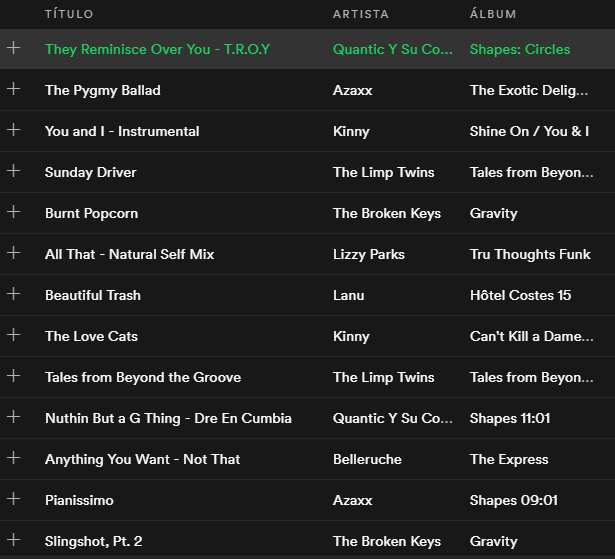

### What about iTunes?
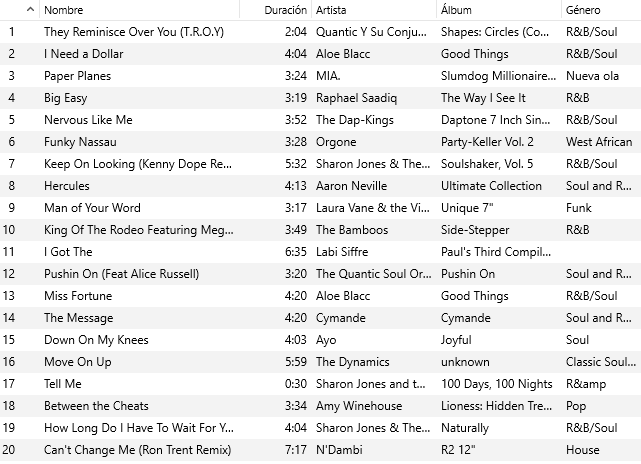

In [27]:
playlist = make_playlist([
    "H:\\Music\\Alfred Brendel\\Schubert_ The Last 3 Piano Sonatas [Disc\\1-05 Schubert_ Piano Sonata #20 In A.m4a"
], size=10, lookback=3)
print_track_details(get_track_details(playlist))

1. Alfred Brendel - Schubert: Piano Sonata #20 In A, D 959 - 1. Allegro
2. Alfred Brendel - Schubert: Piano Sonata #21 In B Flat, D 960 - 1. Molto Moderato
3. Alfred Brendel - Schubert: Piano Sonata #20 In A, D 959 - 4. Rondo: Allegretto
4. Alfred Brendel - Schubert: Klavierstück In E Flat, D 946/2
5. Alfred Brendel - Schubert: Piano Sonata #19 In C Minor, D 958 - 3. Menuetto: Allegro
6. Alfred Brendel - Schubert: Piano Sonata #19 In C Minor, D 958 - 1. Allegro
7. Alfred Brendel - Schubert: Klavierstück In C, D 946/3
8. Alfred Brendel - Schubert: Klavierstück In E Flat Minor, D 946/1
9. Joep Beving - The Gift
10. Alfred Brendel - Schubert: Piano Sonata #19 In C Minor, D 958 - 2. Adagio


In [ ]:
play_playlist(playlist)

Classical and piano only music

In [17]:
playlist = make_playlist([
    "H:\\Music\\Banda sinfónica municipal de Madrid\\El pasodoble\\19 Paquito Chocolatero.m4a"
], size=10, lookback=3)
print_track_details(get_track_details(playlist))

1. Banda sinfónica municipal de Madrid - Paquito Chocolatero
2. Banda sinfónica municipal de Madrid - Puenteareas
3. Banda sinfónica municipal de Madrid - Amparito Roca
4. Banda sinfónica municipal de Madrid - Pepita Creus
5. Banda sinfónica municipal de Madrid - Gerona
6. Banda sinfónica municipal de Madrid - Liria
7. Banda sinfónica municipal de Madrid - Suspiros de España
8. Banda sinfónica municipal de Madrid - Viva el Rumbo
9. Banda sinfónica municipal de Madrid - Gerona
10. Banda sinfónica municipal de Madrid - Liria


In [18]:
play_playlist(playlist)

All pasadobles

In [19]:
playlist = make_playlist([
    "H:\\Music\\Pete Rock & C.L. Smooth\\Mecca & The Soul Brother\\06 Straighten It Out.mp3"
], size=10, lookback=3)
print_track_details(get_track_details(playlist))

1. Pete Rock and C.L. Smooth - Straighten It Out
2. Gamma & Defesis - Slang Teacher
3. Gamma & Defesis - Slang Teacher
4. Galliano - Stoned Again
5. H:\Music\Unknown Artist\Unknown Album\Ud14Wv1BtQrT.128.mp3 - None
6. Red Cloud & Digital Hemp - Afro Latin Concrete
7. A Tribe Called Quest - Footprints
8. Cypress Hill - How I Could Just Kill A Man
9. Cypress Hill - How I Could Just Kill a Man
10. Cypress Hill - Break It Up


In [20]:
play_playlist(playlist)

Hip hop. I have two separate copies of the tracks that are repeated.

In [21]:
playlist = make_playlist([
    "H:\\Music\\Sven Väth\\In the Mix_ The Sound of the Sixteenth S\\11 Battery.m4a"
], size=10, lookback=3)
print_track_details(get_track_details(playlist))

1. Patrick Specke & Daze Maxim - Battery
2. Fudge Fingas - Dindins4dada
3. Massive Attack - Paradise Circus (Breakage's Tight Rope Remix)
4. Yes Please aka Mr Vasovski - More Than I Wished For (Extended Trumpet Mix)
5. Tim Wright - The Crab
6. John Tejada - Cipher
7. Sven Väth - In the Mix: The Sound of the Sixteenth Season (Continuous DJ Mix 1)
8. H:\Music\Unknown Artist\Unknown Album\sven väth mixmag.m4a - None
9. Âme - Rej
10. Tim Green - Body Language, Vol. 18 (Continuous Mix)


In [22]:
play_playlist(playlist)

(European) techno music

In [23]:
playlist = make_playlist([
    "H:\\Music\\Joby Talbot\\Franklyn\\01 Gonna Kill a Man.m4a"
], size=10, lookback=3)
print_track_details(get_track_details(playlist))

1. Joby Talbot - Gonna Kill a Man
2. Joby Talbot - End Credits
3. Krister Linder - Look At Me
4. Thomas Newman - Any Other Name
5. Lars Horntveth - Pooka Soundtrack
6. John Williams - Rey Meets BB-8
7. John Williams - Maz's Counsel
8. John Williams - Torn Apart
9. John Williams - Han and Leia
10. John Williams - Finn's Confession


In [24]:
play_playlist(playlist)

Atmospheric and orchestral soundtracks

In [25]:
playlist = make_playlist([
    "H:\\Music\\Echo & the Bunnymen\\Ocean Rain\\The Killing Moon.mp3"
], size=10, lookback=3)
print_track_details(get_track_details(playlist))

1. Echo & the Bunnymen - The Killing Moon
2. Simple Minds - Don´t You Forget About Me
3. Simple Minds - Alive And Kicking
4. Simple Minds - Promise You A Miracle
5. Simple Minds - Oh Jungleland
6. Simple Minds - Sanctify Yourself
7. The Clash - (White Man) In Hammersmith Palais
8. Simple Minds - Love Song Medley: Sun City / Dance To The Music
9. Duran Duran - A View to a Kill
10. Simple Minds - Ghost Dancing


In [26]:
play_playlist(playlist)

80s pop and rock

In [27]:
playlist = make_playlist([
    "H:\\Music\\Compilations\\Maxima FM Compilation, Vol. 11\\1-07 No Superstar (Full Vocal Radio.m4a"
], size=10, lookback=3)
print_track_details(get_track_details(playlist))

1. Remady - No Superstar (Full Vocal Radio Mix)
2. Maroon 5 - Moves Like Jagger (feat. Christina Aguilera)
3. Shawn Wolf - Moves Like Jagger (I've Got the Moves Like Jagger)
4. Usher - DJ Got Us Fallin' In Love (feat. Pitbull) [feat. Pitbull]
5. Pitbull - Timber (feat. Ke$ha)
6. Olav Basoski - Waterman (Radio Mix)
7. Milk, Sugar & Vaya Con Dios - Hey (Nah Neh Nah) (Milk & Sugar Radio Version)
8. Carl Cox - Ain't It Funky Now-
9. Shapeshifters - Back To Basics (Steve Lawler's Return To Rehab Mix)
10. Freemasons - Love On My Mind (Club Mix)


In [28]:
play_playlist(playlist)

Commercial electronic pop

In [29]:
playlist = make_playlist([
    "H:\\Music\\Fela Kuti\\The Best of Fela\\04 Water No Get Enemy.m4a"
], size=10, lookback=3)
print_track_details(get_track_details(playlist))

1. Fela Kuti - Water No Get Enemy
2. Fela Kuti - Water No Get Enemy
3. Brasil Show - Pot-Pourri: Gostava Tanto De Voce-Que Pena-Toda Menina Baiana-Alem Do Horizonte-Malandro-Se Quiser Chorar Por Mim
4. Brasil Show - Voce Pode
5. Fela Kuti - It's No Possible
6. Ebo Taylor - Love & Death
7. Ebo Taylor - Love and Death (Taken from the Album "Love & Death")
8. Deodato - Also Sprach Zarathustra
9. Manu Dibango - Wouri
10. Romano Rizzati - Vocal '700


In [30]:
play_playlist(playlist)

Mostly Afrofunk with some Brazilian

In [31]:
playlist = make_playlist([
    "H:\\Music\\Estrella Fernández\\Unknown Album\\Estiramientos de pie + meditación se.mp3"
], size=10, lookback=3)
print_track_details(get_track_details(playlist))

1. Estrella Fernández - Estiramientos de pie + meditación sentados (respiración y cuerpo)
2. Estrella - Body Scan
3. Estrella Fernández - Movimientos tumbados
4. H:\Music\Unknown Artist\Unknown Album\MBSR-Session06-11-audio.mp3 - None
5. H:\Music\Unknown Artist\Unknown Album\MBSR-Session01-04-audio.mp3 - None
6. H:\Music\Unknown Artist\Unknown Album\MBSR-Session03-03-audio.mp3 - None
7. Carola García Díaz - Yoga de pie 40´
8. H:\Music\Unknown Artist\Unknown Album\MBSR-Session06-09-audio.mp3 - None
9. H:\Music\Unknown Artist\Unknown Album\MBSR-Session06-14-audio.mp3 - None
10. H:\Music\Unknown Artist\Unknown Album\MBSR-Session08-03-audio.mp3 - None


In [32]:
play_playlist(playlist)

All meditations

In [33]:
playlist = make_playlist([
    "H:\\Music\\Unknown Artist\\Unknown Album\\06 Atlas Shrugged - 06.mp3"
], size=10, lookback=3)
print_track_details(get_track_details(playlist))

1. H:\Music\Unknown Artist\Unknown Album\06 Atlas Shrugged - 06.mp3 - None
2. H:\Music\Unknown Artist\Unknown Album\04 Atlas Shrugged - 04.mp3 - None
3. H:\Music\Unknown Artist\Unknown Album\65 Atlas Shrugged - 65 1.mp3 - None
4. H:\Music\Unknown Artist\Unknown Album\05 Atlas Shrugged - 05.mp3 - None
5. H:\Music\Unknown Artist\Unknown Album\03 Atlas Shrugged - 03.mp3 - None
6. H:\Music\Unknown Artist\Unknown Album\30 Atlas Shrugged - 30 1.mp3 - None
7. H:\Music\Unknown Artist\Unknown Album\29 Atlas Shrugged - 29 1.mp3 - None
8. H:\Music\Unknown Artist\Unknown Album\32 Atlas Shrugged - 32 1.mp3 - None
9. H:\Music\Unknown Artist\Unknown Album\31 Atlas Shrugged - 31 1.mp3 - None
10. H:\Music\Unknown Artist\Unknown Album\18 Atlas Shrugged - 18.mp3 - None


In [34]:
play_playlist(playlist)

All chapters from the same audiobook

### Join the dots
* Choosing the nearest songs ends up generating a meandering playlist
* Instead, as the vector mapping is continuous, we can create a playlist which smoothly "joins the dots" between one song and another
* In this way, we make use of both proximity *and* direction in our vector space
* For example, we could travel from soul to techno via funk and drum 'n' bass...

In [18]:
playlist = join_the_dots([
    "H:\\Music\\Aretha Franklin\\I Never Loved a Man the Way I Love You\\01 Respect.mp3", # soul
    "H:\\Music\\James Brown\\The Godfather - The Very Best of James B\\02 I Got You (I Feel Good).m4a", # funk
    "H:\\Music\\Jurassic 5\\Jurassic 5 LP\\Lesson 6_ The Lecture.mp3", # hip-hop
    "H:\\Music\\Roni Size\\Breakbeat Era - Ultra Obscene\\Terrible Funk.mp3", # drum 'n' bass
    "H:\\Music\\Sven Väth\\In the Mix_ The Sound of the Sixteenth S\\14 Eclipse.m4a", # techno
], n=7)

In [19]:
print_track_details(get_track_details(playlist))

1. Aretha Franklin - Respect
2. Dee Edwards - Why Can't There Be Love
3. Linda Jones - I Just Can’t Live My Life (Without You Babe)  [7" Mix]
4. Carnegie Mellon Jazz Band - The First Thing I Do
5. Helene Smith - Pot Can't Talk About the Kettle
6. Tom Jones - Ain't No Sunshine
7. Janis Joplin - Trust Me
8. James Brown - I Got You (I Feel Good)
9. Chubby Checker - Let's Twist Again
10. Cut Chemist Feat. Hymnal - What's The Altitude
11. Nicolas Repac - Swing Swing
12. Cut Chemist - Lesson 6 - The Lecture (Original Un-Edited Version) [Cut Chemist]
13. Coldcut - Mag
14. Cut Chemist & Shortkut - Live Lesson A (Cut Chemist + Shortkut)
15. Jurassic 5 - Lesson 6: The Lecture
16. Cut Chemist, DJ Shadow & Steinski - Live Lesson B (DJ Shadow + Cut Chemist + Steinski)
17. Wuf Ticket - The Key [Dub]
18. DJ Shadow - Lesson 4 (DJ Shadow)
19. Llorca - The End
20. D.Kay - The Prophet
21. LTJ Bukem feat. MC Conrad - Progression Sessions 7 (Tokio, Japan 2002)
22. Roni Size - Terrible Funk
23. Paul SG - No

In [37]:
play_playlist(playlist)

# Thank you for your attention!